In [1]:
import os
import numpy as np
import pandas as pd
from IPython.display import display
df_sample = pd.read_csv('./data/driving_log.csv')
display(df_sample.head(n=5))

,center,left,right,steering,throttle,brake,speed
0,data/IMG/center_2016_12_01_13_30_48_287.jpg,data/IMG/left_2016_12_01_13_30_48_287.jpg,data/IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,data/IMG/center_2016_12_01_13_30_48_404.jpg,data/IMG/left_2016_12_01_13_30_48_404.jpg,data/IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,data/IMG/center_2016_12_01_13_31_12_937.jpg,data/IMG/left_2016_12_01_13_31_12_937.jpg,data/IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,data/IMG/center_2016_12_01_13_31_13_037.jpg,data/IMG/left_2016_12_01_13_31_13_037.jpg,data/IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,data/IMG/center_2016_12_01_13_31_13_177.jpg,data/IMG/left_2016_12_01_13_31_13_177.jpg,data/IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


In [2]:
df_collect_0 = pd.read_csv('./data_collect_0/driving_log.csv')
df_collect_1 = pd.read_csv('./data_collect_1/driving_log.csv')
display(df_collect_0.head(n=1))
#display(df_collect_1.head(n=1))

,center,left,right,steering,throttle,brake,speed
0,data_collect_0/IMG/center_2017_09_10_00_29_42_...,data_collect_0/IMG/left_2017_09_10_00_29_42_38...,data_collect_0/IMG/right_2017_09_10_00_29_42_3...,0.0,0.0,0.0,0.000005


In [3]:
frames = [df_collect_0, df_collect_1]
df = pd.concat(frames)

In [4]:
from sklearn.cross_validation import train_test_split
df_train, df_val = train_test_split(df, test_size=0.2)

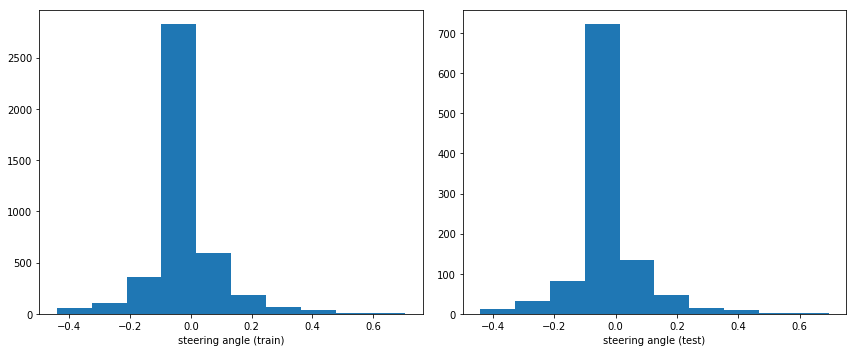

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
df_train['steering'].plot.hist()
plt.ylabel('')
plt.xlabel('steering angle (train)')
plt.subplot(1, 2, 2)
df_val['steering'].plot.hist()
plt.ylabel('')
plt.xlabel('steering angle (test)')
plt.tight_layout()
#plt.savefig('train_test_angle.jpg')
plt.show()

In [6]:
import cv2
def image_flip(image, angle):
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        angle = -angle
    return image, angle

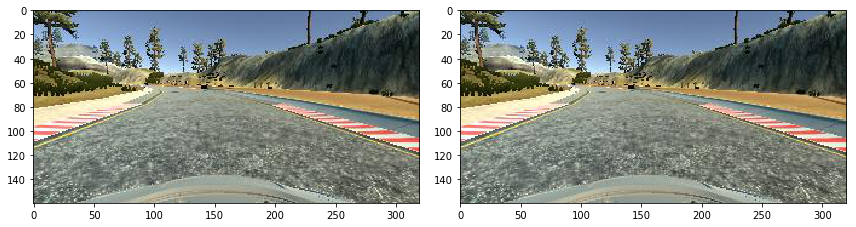

In [7]:
image_example = cv2.imread('data_collect_0/IMG/center_2017_09_10_00_29_47_667.jpg')
image_example = cv2.cvtColor(image_example, cv2.COLOR_BGR2RGB)
image_example_, angle_example_= image_flip(image_example, -0.02352941)
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.imshow(image_example)
plt.subplot(1, 2, 2)
plt.imshow(image_example_)
plt.tight_layout()
#plt.savefig('image_flip.jpg')
plt.show()

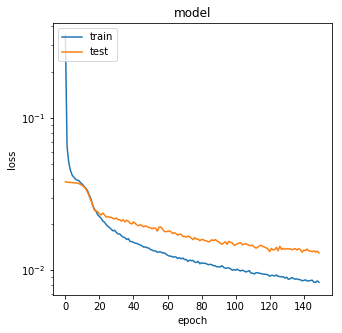

In [8]:
import pickle
model_history = pickle.load(open( "model_history.p", "rb" ))
plt.figure(figsize=(6,6))
plt.plot(model_history['loss'])
plt.plot(model_history['val_loss'])
plt.title('model')
plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('loss.jp')

In [9]:
CENTER = "center"
LEFT = "left"
RIGHT = "right"
STEERING = "steering"
cam_corrections = { CENTER : 0, LEFT : 0.2, RIGHT : -0.2}

In [10]:
BATCH_SIZE=32
from sklearn.utils import shuffle
def generator(df, is_training, batch_size=BATCH_SIZE):
    num_samples = df.shape[0] #or df['center'].count()
    while 1:
        shuffle(df) # or df.sample(frac=1).reset_index(drop=True)
        for offset in range(0, num_samples, batch_size):
            df_batch = df.iloc[offset:offset + batch_size] #slice wont raise out of bound exception
            images = []
            angles = []
            for index, row in df_batch.iterrows():
                for pos in cam_corrections:
                    image = cv2.imread(os.path.join('./', row[pos].strip()))
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    angle = row[STEERING] + cam_corrections[pos]
                    if is_training:
                        image, angle = image_flip(image, angle)
                    
                    images.append(image)
                    angles.append(angle)
            
            X_train = np.array(images)
            y_train = np.array(angles)
            yield X_train, y_train

In [11]:
from keras.models import Sequential
from keras.layers import Input, Lambda
from keras.layers import Dropout, Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D, Cropping2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [12]:
model = Sequential()
model.add(Cropping2D(cropping=((40, 40), (0, 0)), input_shape=(160, 320, 3)))
model.add(BatchNormalization())
#cov2d 1
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(5, 5)))
model.add(Dropout(0.2))
#conv2d 2
model.add(Conv2D(96, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.2))
#conv2d 3
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.2))
#flatten
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

In [13]:
callbacks = [EarlyStopping(monitor='val_loss', patience=30, verbose=0),
             ModelCheckpoint('model_new.hdf5', monitor='val_loss', save_best_only=True, verbose=0)]

In [14]:
EPOCHS = 150
adam_opt=Adam(lr=5e-5)
model.compile(adam_opt, 'mse', ['accuracy'])
model_history_new = model.fit_generator(generator(df_train, False), epochs=EPOCHS,
                                    steps_per_epoch=int(df_train.shape[0]/BATCH_SIZE),
                                    validation_data=generator(df_val, True),
                                    validation_steps=int(df_val.shape[0]/BATCH_SIZE),
                                    callbacks = callbacks)

Epoch 1/150
132/132 [==============================] - 22s - loss: 0.0984 - acc: 0.1629 - val_loss: 0.0390 - val_acc: 0.1689
Epoch 2/150
132/132 [==============================] - 21s - loss: 0.0443 - acc: 0.1731 - val_loss: 0.0380 - val_acc: 0.1698
Epoch 3/150
132/132 [==============================] - 20s - loss: 0.0407 - acc: 0.1729 - val_loss: 0.0379 - val_acc: 0.1698
Epoch 4/150
132/132 [==============================] - 20s - loss: 0.0388 - acc: 0.1731 - val_loss: 0.0374 - val_acc: 0.1698
Epoch 5/150
132/132 [==============================] - 20s - loss: 0.0371 - acc: 0.1728 - val_loss: 0.0361 - val_acc: 0.1698
Epoch 6/150
132/132 [==============================] - 20s - loss: 0.0355 - acc: 0.1731 - val_loss: 0.0345 - val_acc: 0.1698
Epoch 7/150
132/132 [==============================] - 20s - loss: 0.0336 - acc: 0.1731 - val_loss: 0.0319 - val_acc: 0.1698
Epoch 8/150
132/132 [==============================] - 20s - loss: 0.0301 - acc: 0.1734 - val_loss: 0.0290 - val_acc: 0.1698


132/132 [==============================] - 20s - loss: 0.0104 - acc: 0.1730 - val_loss: 0.0162 - val_acc: 0.1698
Epoch 67/150
132/132 [==============================] - 20s - loss: 0.0105 - acc: 0.1732 - val_loss: 0.0170 - val_acc: 0.1698
Epoch 68/150
132/132 [==============================] - 20s - loss: 0.0103 - acc: 0.1729 - val_loss: 0.0163 - val_acc: 0.1698
Epoch 69/150
132/132 [==============================] - 20s - loss: 0.0102 - acc: 0.1730 - val_loss: 0.0167 - val_acc: 0.1698
Epoch 70/150
132/132 [==============================] - 20s - loss: 0.0101 - acc: 0.1730 - val_loss: 0.0163 - val_acc: 0.1698
Epoch 71/150
132/132 [==============================] - 20s - loss: 0.0102 - acc: 0.1730 - val_loss: 0.0162 - val_acc: 0.1698
Epoch 72/150
132/132 [==============================] - 20s - loss: 0.0102 - acc: 0.1731 - val_loss: 0.0162 - val_acc: 0.1698
Epoch 73/150
132/132 [==============================] - 20s - loss: 0.0099 - acc: 0.1730 - val_loss: 0.0162 - val_acc: 0.1698
Epoch

132/132 [==============================] - 21s - loss: 0.0078 - acc: 0.1730 - val_loss: 0.0134 - val_acc: 0.1698
Epoch 131/150
132/132 [==============================] - 21s - loss: 0.0079 - acc: 0.1728 - val_loss: 0.0137 - val_acc: 0.1698
Epoch 132/150
132/132 [==============================] - 21s - loss: 0.0077 - acc: 0.1734 - val_loss: 0.0137 - val_acc: 0.1698
Epoch 133/150
132/132 [==============================] - 21s - loss: 0.0078 - acc: 0.1734 - val_loss: 0.0133 - val_acc: 0.1698
Epoch 134/150
132/132 [==============================] - 21s - loss: 0.0076 - acc: 0.1719 - val_loss: 0.0135 - val_acc: 0.1698
Epoch 135/150
132/132 [==============================] - 21s - loss: 0.0076 - acc: 0.1731 - val_loss: 0.0135 - val_acc: 0.1698
Epoch 136/150
132/132 [==============================] - 21s - loss: 0.0077 - acc: 0.1729 - val_loss: 0.0135 - val_acc: 0.1698
Epoch 137/150
132/132 [==============================] - 21s - loss: 0.0077 - acc: 0.1731 - val_loss: 0.0136 - val_acc: 0.169

In [15]:
import matplotlib.pyplot as plt
def plot_model_stats(model_history, model_name):
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(model_history.history['acc'])
    plt.plot(model_history.history['val_acc'])
    plt.title(model_name)
    plt.yscale('log')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title(model_name)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

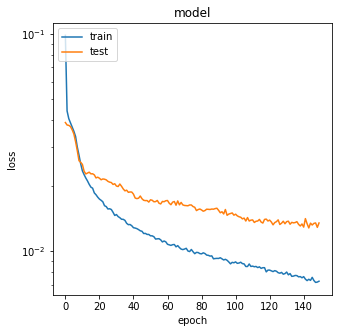

In [17]:
plt.figure(figsize=(5,5))
plt.plot(model_history_new.history['loss'])
plt.plot(model_history_new.history['val_loss'])
plt.title('model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'test'], loc='upper left')
plt.show()